In this Notebook we create and sketch tools for the Agent. Building proofs of concept (PoC)

### Setup

In [1]:
# Libraries

import os

In [2]:
# Local Modules


In [3]:
# import Whisper

import whisper

In [4]:
# Import Agent

os.sys.path.append("../src")
os.sys.path.append("../src/agents")

import react  # My AI assistant

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


In [5]:
os.sys.path.append("../src/utils")

from gaia_eval import get_agent_response, evaluate_response

In [6]:

# Import GAIA Questions
from datasets import load_dataset


/home/santiagoal/.cache/pypoetry/virtualenvs/chappie-CHLGiFC_-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

import pandas as pd


In [8]:
from dotenv import load_dotenv
from huggingface_hub import snapshot_download, login

In [9]:
# Load Hugging face credentials

#load_dotenv()
#login(os.getenv(key="HF_TOKEN_CHAPPIE"))  # Replace with your hf api key name


In [10]:
#gaia_questions_path = snapshot_download(repo_id="gaia-benchmark/GAIA", repo_type="dataset")
#gaia_questions = load_dataset(path="gaia-benchmark/GAIA", name="2023_level1")

In [11]:
gaia_index_dir = "../../../.cache/huggingface/datasets/gaia-benchmark___gaia/2023_level1/0.0.1/ec492fe4320ee795b1aed6bb46229c5f693226b0f1316347501c24b4baeee005"
#gaia_index_dir = os.path.abspath(gaia_index_dir)
gaia_data_path = os.path.join(gaia_index_dir, "gaia-validation.arrow")

In [12]:
# Temporal cell: wrote because of hugging face api calls limit

import pyarrow.ipc as ipc

with open(gaia_data_path, "rb") as f:
    reader = ipc.RecordBatchStreamReader(f)
    table = reader.read_all()

gaia_df = table.to_pandas()


In [13]:
#gaia_questions = gaia_questions["validation"]  # Filter for dev purposes
#gaia_df = pd.DataFrame(gaia_questions)

In [14]:
gaia_df.head()

,task_id,Question,Level,Final answer,file_name,file_path,Annotator Metadata
0,e1fc63a2-da7a-432f-be78-7c4a95598703,If Eliud Kipchoge could maintain his record-ma...,1,17,,,{'Steps': '1. Googled Eliud Kipchoge marathon ...
1,8e867cd7-cff9-4e6c-867a-ff5ddc2550be,How many studio albums were published by Merce...,1,3,,,{'Steps': '1. I did a search for Mercedes Sosa...
2,ec09fa32-d03f-4bf8-84b0-1f16922c3ae4,Here's a fun riddle that I think you'll enjoy....,1,3,,,{'Steps': 'Step 1: Evaluate the problem statem...
3,5d0080cb-90d7-4712-bc33-848150e917d3,What was the volume in m^3 of the fish bag tha...,1,0.1777,,,"{'Steps': '1. Searched '""Can Hiccup Supply Eno..."
4,a1e91b78-d3d8-4675-bb8d-62741b4b68a6,In the video https://www.youtube.com/watch?v=L...,1,3,,,{'Steps': '1. Navigate to the YouTube link. 2....


---

In [15]:
filetypes = {d[1].file_path.split(".")[-1] for d in gaia_df.iterrows()}
filetypes

{'', 'docx', 'mp3', 'png', 'pptx', 'py', 'txt', 'xlsx'}

## Image Handler Tools

### Identify Image-like tasks

In [16]:
img_filetypes = ('png', 'jpg')

In [17]:
image_tasks_df = gaia_df[gaia_df["file_path"].apply(lambda row: row.split(".")[-1] in img_filetypes)]
image_tasks_df

,task_id,Question,Level,Final answer,file_name,file_path,Annotator Metadata
16,cca530fc-4052-43b2-b130-b30968d8aa44,Review the chess position provided in the imag...,1,Rd5,cca530fc-4052-43b2-b130-b30968d8aa44.png,/home/santiagoal/.cache/huggingface/hub/datase...,{'Steps': 'Step 1: Evaluate the position of th...
21,9318445f-fe6a-4e1b-acbf-c68228c9906a,"As a comma separated list with no whitespace, ...",1,"3/4,1/4,3/4,3/4,2/4,1/2,5/35,7/21,30/5,30/5,3/...",9318445f-fe6a-4e1b-acbf-c68228c9906a.png,/home/santiagoal/.cache/huggingface/hub/datase...,{'Steps': '1. Find the fractions that use / as...


In [18]:
image_tasks_df.iloc[0]

task_id                            cca530fc-4052-43b2-b130-b30968d8aa44
Question              Review the chess position provided in the imag...
Level                                                                 1
Final answer                                                        Rd5
file_name                      cca530fc-4052-43b2-b130-b30968d8aa44.png
file_path             /home/santiagoal/.cache/huggingface/hub/datase...
Annotator Metadata    {'Steps': 'Step 1: Evaluate the position of th...
Name: 16, dtype: object

In [19]:
chess_task = image_tasks_df.iloc[0]

In [20]:
os.path.isfile(chess_task.file_path)

True

libpng warning: iCCP: known incorrect sRGB profile


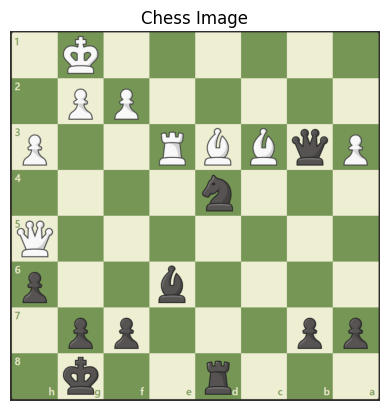

In [21]:
import cv2
import matplotlib.pyplot as plt

image_path = chess_task.file_path
image_bgr = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Chess Image")
plt.axis("off")
plt.show()


### Chess Tool

In this section, our methodology is to 

1. Use a CV model to get the FEN position of a 2D chess image
2. Usea another model (likely stockfish) to predict the best move from a FEN position

#### Tool POC

To extract the FEN position from the board image, we used [board_to_fen](https://github.com/mcdominik/board_to_fen)

In [22]:
import cairosvg
from io import BytesIO
import numpy as np

In [ ]:
from PIL import Image
from board_to_fen.predict import get_fen_from_image

img = Image.open(chess_task.file_path)
fen = get_fen_from_image(img, black_view=True)

2025-06-18 15:42:51.072071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 15:42:51.542556: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 15:42:51.619714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/santiagoal/.cache/pypoetry/virtualenvs/chappie-CHLGiFC_-py3.9/lib/python3.9/s

In [24]:
fen

'3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1'

We observed this position has no enough information about the current position, so we need to post process it:

In [25]:
fen_cleaned = fen + " b - - 0 1"

In [26]:
fen_cleaned

'3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1 b - - 0 1'

Looking forward, we will need to a warn the AI agent to post-process the FEN before passing to stockfish. However, we can validate the prected FEN 

In [27]:
# try out with pychess

import chess as c
import chess.engine as ce

board = c.Board(fen_cleaned)

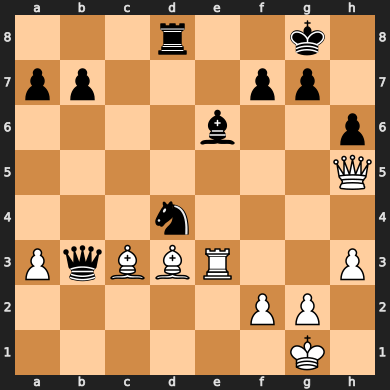

In [28]:
board

In [29]:
svg_data = c.svg.board(board=board, flipped=True)
png_data = BytesIO()
cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to=png_data)
png_data.seek(0)
img_array = np.asarray(bytearray(png_data.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.COLOR_BGR2RGB)

libpng warning: iCCP: known incorrect sRGB profile


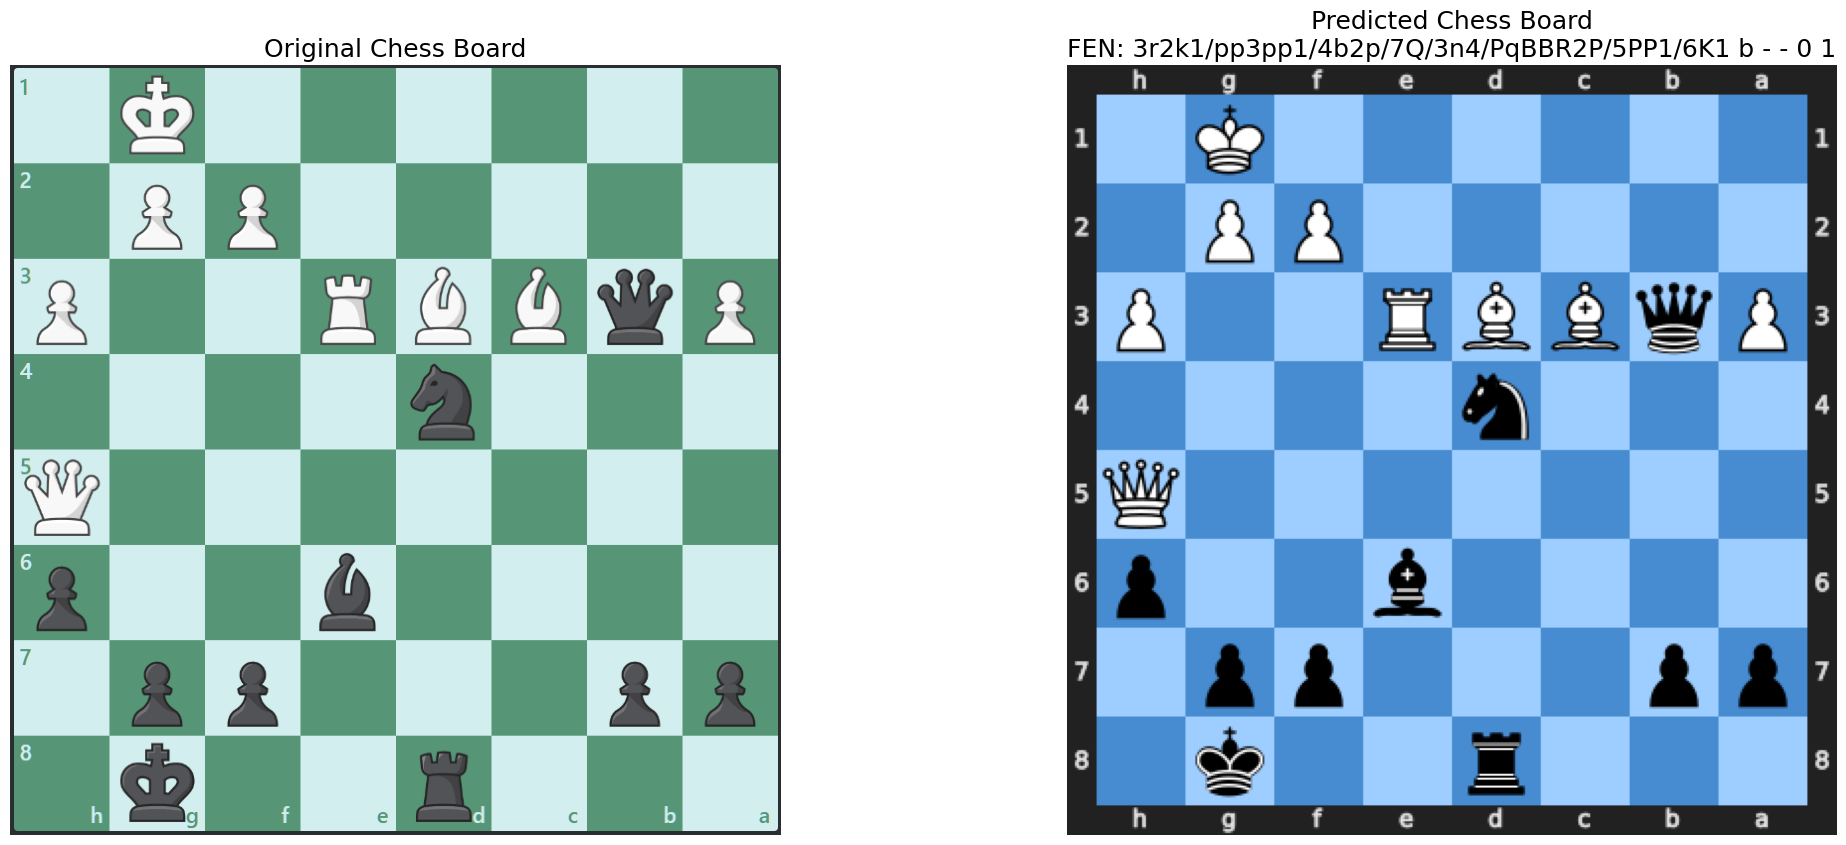

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

ax[0].imshow(cv2.imread(chess_task.file_path))
ax[0].axis("off")
ax[0].set_title("Original Chess Board", fontsize=18)

ax[1].imshow(img)
ax[1].axis("off")
ax[1].set_title(f"Predicted Chess Board\nFEN: {fen_cleaned}", fontsize=18)
plt.show()

Once we extracted the FEN chess position, we pass it to Stockfish in order to get the best next move

In [31]:
# Import Stockfish 
stockfish_path = "../external/chess-engines/stockfish/stockfish-ubuntu-x86-64-avx2"
chess_engine = ce.SimpleEngine.popen_uci(stockfish_path)

In [32]:
# Predict next best move 
stockfish_player = chess_engine.play(board=board, limit=ce.Limit(time=10))
best_move_uci = stockfish_player.move
best_move = board.san(move=best_move_uci) # Convert from Universal Chess interface to Standard Algebraic Notation
best_move

'Rd5'

In [33]:
print(
    "Results\n",
    "=" * 30,
    f"\nPredicted best next move: {best_move}",
    f"\nCorrect Answer: {chess_task['Final answer']}"
    f"\nIs the prediction correct?: {'yes' if best_move==chess_task['Final answer'] else 'no'}"
    )

Results
Predicted best next move: Rd5 
Correct Answer: Rd5
Is the prediction correct?: yes


There we go! our model finds the correct answer

### Object detection tool

#### (2/2) YoLo for Object Detection 

### Integrate Tool and Experiment

---

## Audio Tool

Let's study where does our current Agent fail, especially on audio-like questions

In [ ]:
run = False

In [ ]:
gaia_df

### Identify Audio-like tasks

The first questions is to understand which questions need audio? 

* Hypothesis: Just look at such questions that have a .mp3 file attached


In [ ]:
# Gather a sample file from any task

audio_tasks = gaia_df[(gaia_df["file_path"].str.len()>0) & (gaia_df["file_path"].str.endswith(".mp3"))]
sample_task = audio_tasks.iloc[0]

In [ ]:
print(f"{(audio_tasks.shape[0] / gaia_df.shape[0]) * 100:.1f}% of tasks need audio processing")

In [ ]:
sample_task

In [ ]:
# Get the sample file

filepath = sample_task["file_path"]


Let's import the mp3 file with [ffmpeg](https://stackoverflow.com/questions/9458480/read-mp3-in-python-3#:~:text=%24%20ffmpeg%20%2Di%20foo.mp3%20%2Dvn%20%2Dacodec%20pcm_s16le%20%2Dac%201%20%2Dar%2044100%20%2Df%20wav%20foo.wav)

In [ ]:
temp_data_path = "/home/santiagoal/current-projects/chappie/data/temp-data/"

In [ ]:
if run:
    os.system(f"ffmpeg -i {filepath} -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav {temp_data_path}sample_audio.wav")

In [ ]:
if run:
    use_gpu = False
    model_size = "tiny"

    model = (
        whisper.load_model(model_size).cuda()
        if use_gpu
        else whisper.load_model(model_size)
    )

In [ ]:
print(filepath)

In [ ]:
if run: 
    raw_transcript = model.transcribe(
            filepath,
            word_timestamps=False,
            no_speech_threshold=0.5,
            condition_on_previous_text=True,
            compression_ratio_threshold=2.0,
        )

    transcript = raw_transcript["text"]
    print(transcript)

### Tool POC


In [ ]:

if run: 
    def transcriber(audio_path: str, ai_model = model) -> str:
        """
        Transcribes an audio file

        Parameters
        ----------
        audio_path : str
            Path to the audio file
        ai_model
            audio-to-text AI model 

        Returns:
            str: Text of the transcript 
        """
        raw_transcript = ai_model.transcribe(
            audio_path,
            word_timestamps=False,
            no_speech_threshold=0.5,
            condition_on_previous_text=True,
            compression_ratio_threshold=2.0,
        )

        transcript = raw_transcript["text"]

        return transcript

### Integrate Tool POC and experiment


The changes have been integrated, now we will experiment with the new version of the agent

In [ ]:
audio_tasks["Agent response"] = audio_tasks.apply(func=get_agent_response, axis=1)
audio_tasks["is_correct"] = audio_tasks.apply(func=eval_answer, axis=1)

In [ ]:
audio_tasks

In [ ]:
# Next steps: Update model... 